<a href="https://colab.research.google.com/github/GAKIZAB/Analyse-des-tendances-de-consommation-sur-les-r-seaux-sociaux/blob/main/Analyse_des_tendances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
data = pd.read_csv('sentimentdataset.csv')
data.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


In [7]:
data.describe()

,Unnamed: 0.1,Unnamed: 0,Retweets,Likes,Year,Month,Day,Hour
count,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000
mean,366.464481,369.740437,21.508197,42.901639,2020.471311,6.122951,15.497268,15.521858
std,211.513936,212.428936,7.061286,14.089848,2.802285,3.411763,8.474553,4.113414
min,0.000000,0.000000,5.000000,10.000000,2010.000000,1.000000,1.000000,0.000000
25%,183.750000,185.750000,17.750000,34.750000,2019.000000,3.000000,9.000000,13.000000
50%,366.500000,370.500000,22.000000,43.000000,2021.000000,6.000000,15.000000,16.000000
75%,549.250000,553.250000,25.000000,50.000000,2023.000000,9.000000,22.000000,19.000000
max,732.000000,736.000000,40.000000,80.000000,2023.000000,12.000000,31.000000,23.000000


In [8]:
data.nunique()

,0
Unnamed: 0.1,732
Unnamed: 0,732
Text,707
Sentiment,279
Timestamp,683
User,685
Platform,4
Hashtags,697
Retweets,26
Likes,38


In [51]:
# 3. Replace all variants of 'Twitter' with a single label
data['Platform'] = data['Platform'].str.strip()

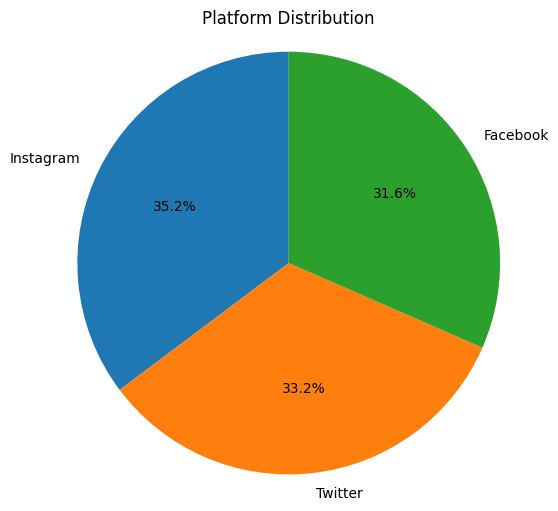

In [57]:
df = data.copy()
# Prepare data for the pie chart
labels = ['Instagram','Twitter','Facebook']
sizes = df['Platform'].value_counts()

# Plot a pie chart showing the distribution of Platform
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Platform Distribution')
plt.axis('equal')
plt.show()

In [56]:
df['Platform'].value_counts()

,count
Platform,
Instagram,258
Twitter,243
Facebook,231


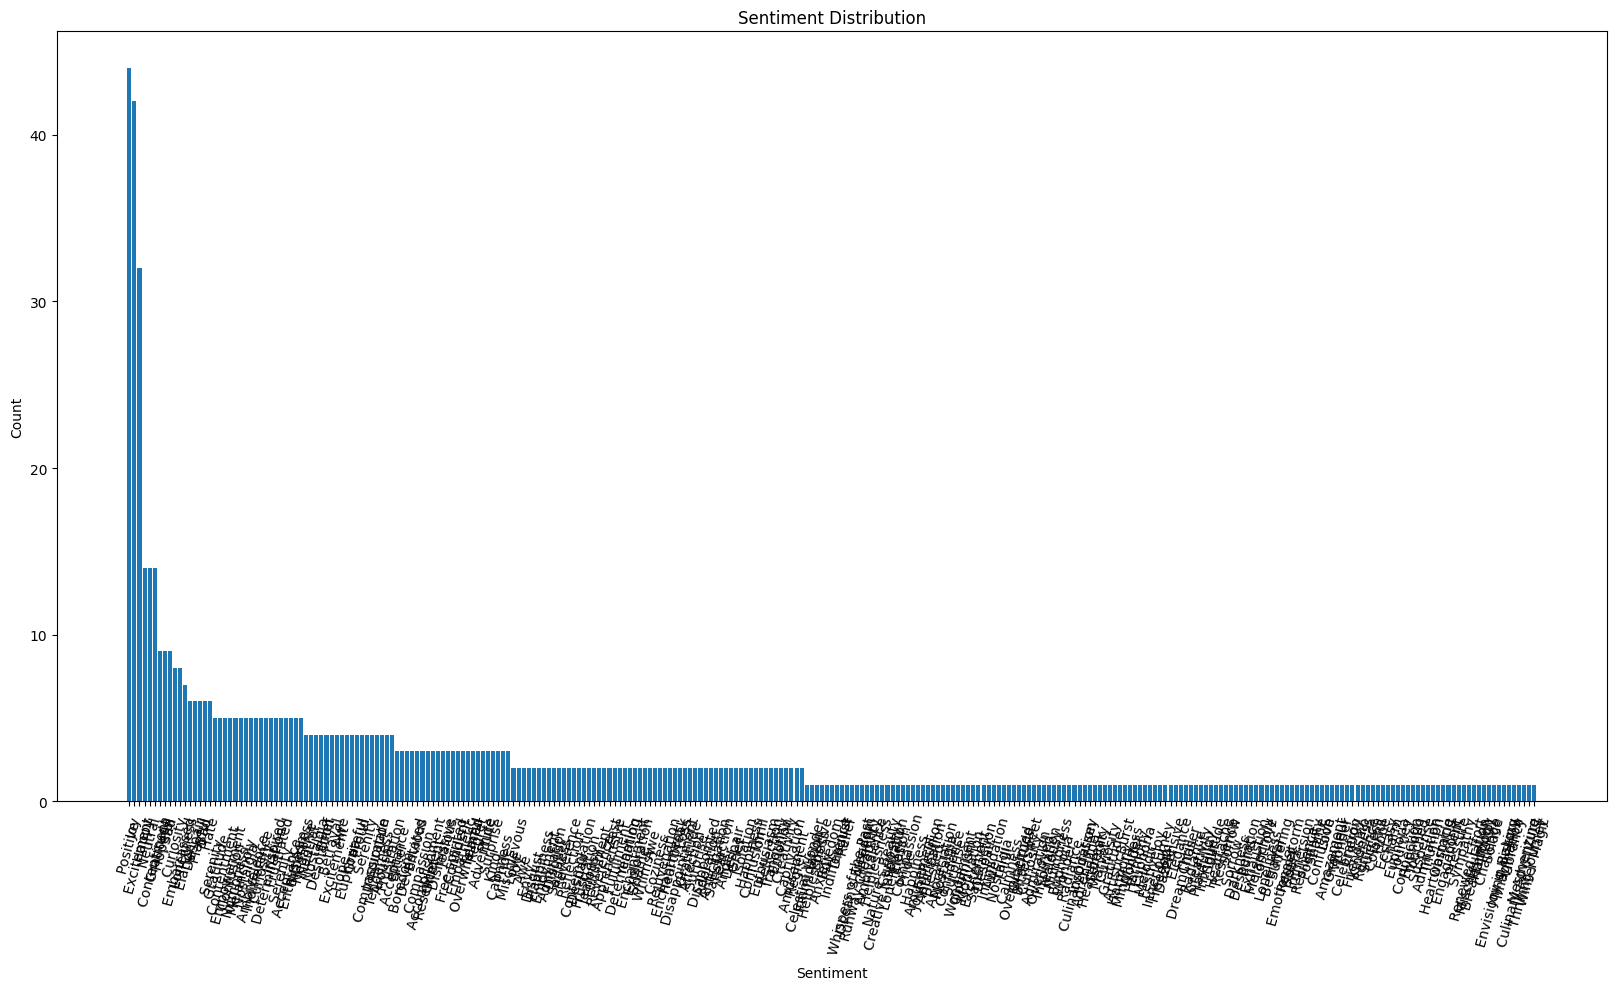

In [38]:
# Prepare data for the bar chart
sentiment_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(20,10))
plt.bar(sentiment_counts.index, sentiment_counts.values) # Use the index for categories and values for counts
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=75)
plt.show()

<Axes: xlabel='Platform', ylabel='Likes'>

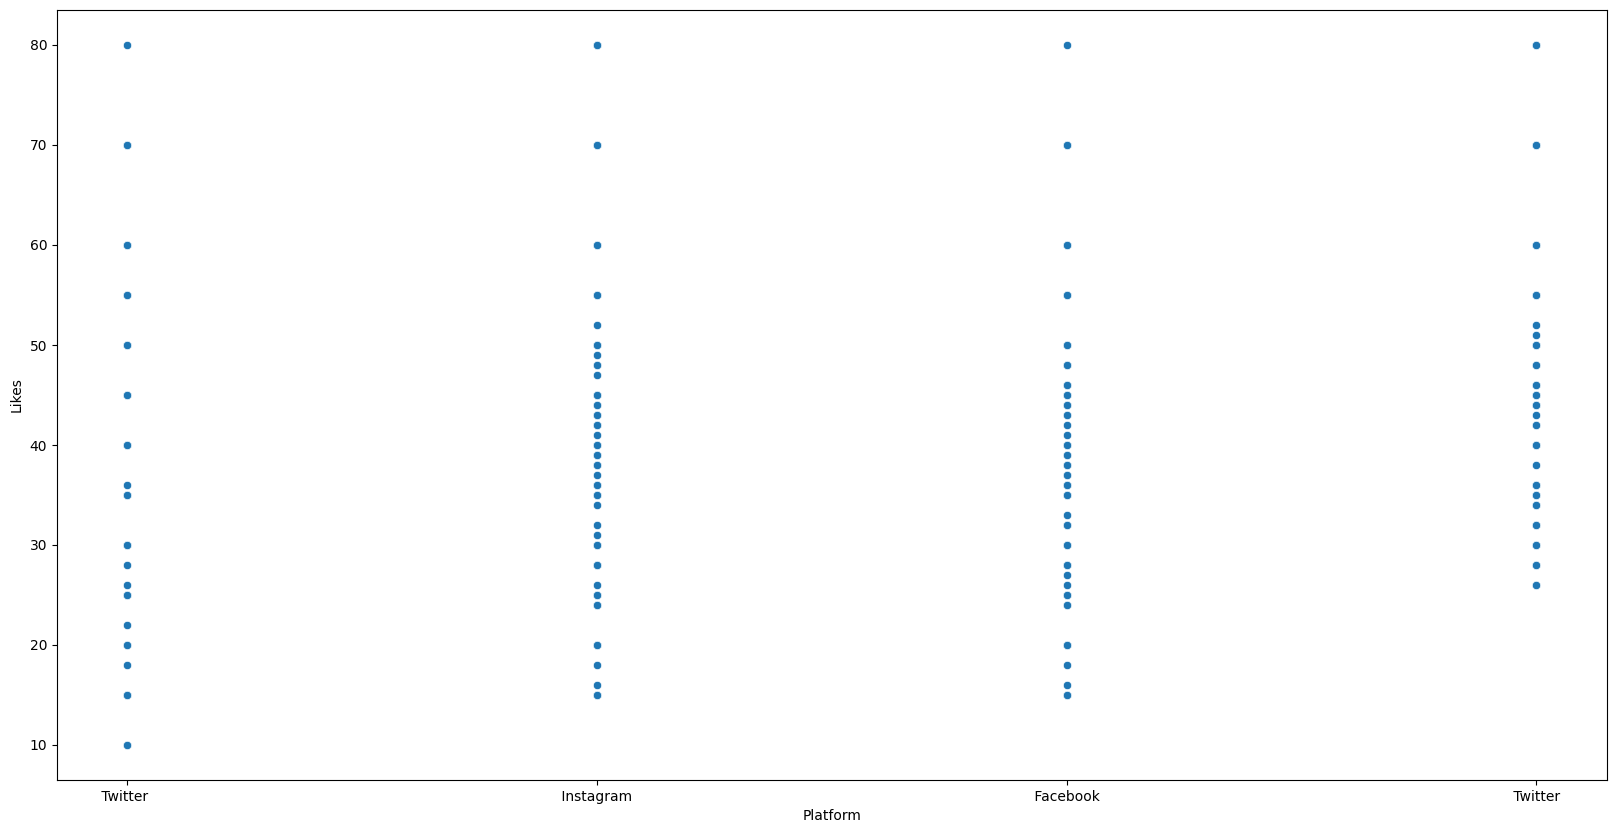

In [43]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='Platform', y='Likes', data=df)

In [42]:
df.columns

Index(['Text', 'Sentiment', 'Timestamp', 'User', 'Platform', 'Hashtags',
       'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

In [10]:
pip install geoip2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.3 MB/s eta 0:00:00


In [11]:
import geoip2.database


reader = geoip2.database.Reader('/chemin/GeoLite2-Country.mmdb')
def ip_to_country(ip):
    try:
        return reader.country(ip).country.iso_code
    except:
        return None

df['pays'] = df['ip'].apply(ip_to_country)


FileNotFoundError: [Errno 2] No such file or directory: b'/chemin/GeoLite2-Country.mmdb'